In [1]:
#!pip install matplotlib
#!pip install torch
#!pip install gym

In [2]:
#Import neccessary libraries
import gym
from gym import spaces
import numpy as np
import copy
import numpy as np
import math as m
import random as r
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
"""
from IPython import display
from collections import namedtuple
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import count
import torch.nn.functional as F
"""

'\nfrom IPython import display\nfrom collections import namedtuple\nimport torch.nn as nn\nimport torch.optim as optim\nfrom collections import deque\nfrom itertools import count\nimport torch.nn.functional as F\n'

In [3]:
import gym
import Zelda_my_vre
# Register the environment
gym.register(
    id='vehicleRouting-v0',
    entry_point='Zelda_my_vre:vehicleRoutingEnv',
    kwargs={'current_customer_list': None, 'current_truck_capacity': None, 'total_truck_capacity': None, 'depot_location': None}
)

In [4]:
#Generate random problem instance, generating random values (some within range, like demand) for matrices and locations
#self, info_vector, customer_location_matrix, truck_location_matrix, customer_demand_matrix, truck_capacity_matrix, customer_timeframe_matrix, truck_timeframe_matrix, customer_location_tuple_list
#Generate instance function would be entirely seperate from solver
#Outer creates problem instance, then calls solve entire problem, input tuple of location
def instance_creator(cust_max_dem, truck_cap, num_cust, num_row, num_col):
    depot = (r.randint(0,num_row-1),r.randint(0,num_col)-1)
    occupied_coords=[]
    occupied_coords.append(depot)
    current_customer_list=[]
    current_customer_list.append(depot)
    for cust in range(num_cust):
        customer=[]
        coord=depot
        while coord in occupied_coords:
            coord=(r.randint(0,num_row-1),r.randint(0,num_col)-1)
        occupied_coords.append(coord)
        customer.append(coord)
        demand=(r.randint(0,cust_max_dem))
        customer.append(demand)
        distance_to_depot=dist = (m.sqrt(((depot[0]-coord[0])**2)+(depot[1]-coord[1])**2))
        customer.append(distance_to_depot)
        distance_to_truck=distance_to_depot
        customer.append(distance_to_truck)
        position_to_depot=(coord[0]-depot[0],coord[1]-depot[1])
        customer.append(position_to_depot)
        position_to_truck=position_to_depot
        customer.append(position_to_truck)
        current_customer_list.append(customer)
    current_truck_capacity=truck_cap
    total_truck_capacity=truck_cap
    return current_customer_list, current_truck_capacity, total_truck_capacity, depot
    

## Define the problem values

In [5]:
#Defining problem instance variables
#Changing the numbers, changes the single instance NN is training
cust_max_dem = 5
truck_cap = 10
num_cust =25
num_row = 25
num_col = 25

## Create instance and initialize environment

In [6]:
#Creating problem instance using defined variables
current_customer_list, current_truck_capacity, total_truck_capacity, depot_location = \
instance_creator(cust_max_dem, truck_cap, num_cust, num_row, num_col)

In [7]:
print(f"Current Customer List: {current_customer_list}")
print(f"Depot: {depot_location}")

Current Customer List: [(20, 9), [(24, 2), 0, 8.06225774829855, 8.06225774829855, (4, -7), (4, -7)], [(24, 0), 1, 9.848857801796104, 9.848857801796104, (4, -9), (4, -9)], [(20, 10), 0, 1.0, 1.0, (0, 1), (0, 1)], [(12, 14), 1, 9.433981132056603, 9.433981132056603, (-8, 5), (-8, 5)], [(12, 2), 1, 10.63014581273465, 10.63014581273465, (-8, -7), (-8, -7)], [(23, 17), 3, 8.54400374531753, 8.54400374531753, (3, 8), (3, 8)], [(24, -1), 1, 10.770329614269007, 10.770329614269007, (4, -10), (4, -10)], [(3, 2), 4, 18.384776310850235, 18.384776310850235, (-17, -7), (-17, -7)], [(18, 3), 1, 6.324555320336759, 6.324555320336759, (-2, -6), (-2, -6)], [(2, 14), 2, 18.681541692269406, 18.681541692269406, (-18, 5), (-18, 5)], [(3, 3), 4, 18.027756377319946, 18.027756377319946, (-17, -6), (-17, -6)], [(8, 9), 2, 12.0, 12.0, (-12, 0), (-12, 0)], [(7, 23), 3, 19.1049731745428, 19.1049731745428, (-13, 14), (-13, 14)], [(23, 12), 5, 4.242640687119285, 4.242640687119285, (3, 3), (3, 3)], [(23, -1), 5, 10.4403

In [8]:
# Test the environment
# Making the enviromenet, using the created matrices from the creeated problem instance
env = gym.make('vehicleRouting-v0', current_customer_list=current_customer_list, \
               current_truck_capacity=current_truck_capacity, \
               total_truck_capacity=total_truck_capacity, depot_location=depot_location)
#Checks if you are in ipython enviroment
is_ipython = 'inline' in matplotlib.get_backend()
#If true, then import display which is used later for the visual plots
if is_ipython:
    from IPython import display
#Makes the plots interactive, so that the plots are visualized and changing as new data is being created
plt.ion()
#Check if there is dedicated GPU, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
#Defining the environment action space number and reset environment
n_actions=env.action_space.n
state, info =env.reset()

/home/aidan/anaconda3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/aidan/anaconda3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/aidan/anaconda3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
/home/aidan/anaconda3/envs/rl/lib/python3.10/site-packages/gym/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [10]:
#Testing the render function
env.render()

States: [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 20, 9, 24, 2, 0, 8.06225774829855, 8.06225774829855, 4, -7, 4, -7, 24, 0, 1, 9.848857801796104, 9.848857801796104, 4, -9, 4, -9, 20, 10, 0, 1.0, 1.0, 0, 1, 0, 1, 12, 14, 1, 9.433981132056603, 9.433981132056603, -8, 5, -8, 5, 12, 2, 1, 10.63014581273465, 10.63014581273465, -8, -7, -8, -7, 23, 17, 3, 8.54400374531753, 8.54400374531753, 3, 8, 3, 8, 24, -1, 1, 10.770329614269007, 10.770329614269007, 4, -10, 4, -10, 3, 2, 4, 18.384776310850235, 18.384776310850235, -17, -7, -17, -7, 18, 3, 1, 6.324555320336759, 6.324555320336759, -2, -6, -2, -6, 2, 14, 2, 18.681541692269406, 18.681541692269406, -18, 5, -18, 5, 3, 3, 4, 18.027756377319946, 18.027756377319946, -17, -6, -17, -6, 8, 9, 2, 12.0, 12.0, -12, 0, -12, 0, 7, 23, 3, 19.1049731745428, 19.1049731745428, -13, 14, -13, 14, 23, 12, 5, 4.242640687119285, 4.242640687119285, 3, 3, 3, 3, 23, -1, 5, 10.44030650891055, 10.44030650891055, 3, -10, 3, -10, 4, 9,

In [11]:
#Defining transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Creating replay memory class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return r.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
#Defining DQN class, input layer is the observations (flattened states list)
#Two layers of 128 nodes each
#Output layer of the number of actions
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        print(f'*** Initializing with {n_observations}, {n_actions}')
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
#        x = F.relu(self.layer3(x))
        return self.layer3(x)

## Test Single Step

In [13]:
def select_action(state, exclude_indices):
    global steps_done
    sample = r.random()
#Eps threshold is used for exploitation vs exploration
#When the sample is greater than the calculated eps threshold, then the NN is taking the policy selected action (exploitation)
#When the sample is not greater, then the NN is choosing a random action (exploration)
#The ending eps value is added to the difference between the starting and ending epsilon value, which would
#This is multiplied by e^(-1 times the number of steps over the decay value of 1000). Meaning that as the number
#of steps increase than -1 is multiplied by a larger fraction and therefore, the expression, m.exp(-1. * steps_done / EPS_DECAY)
#is becoming a smaller fraction. And since the fraction is being multplied by eps end and the difference of end and start,
#the entire express is decreasing over time, and therefore, more samples are greater than the threshold leading
#to more exploitation
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        m.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # DEBUG
#    sample = 1.0
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # Create a mask for the actions to exclude
            action_values = policy_net(state)
            #print(f"action_values: {action_values}")
            #Create array of boolean values for the mask
            exclude_mask = torch.full_like(action_values, float('0'), dtype=torch.bool)
            #Sets corresponding values in row 0 of exclude mask to True if exclude indicies indicates it
            exclude_mask[0,exclude_indices] = True
            #print(f"exclude_mask: {exclude_mask}")
            #Sets masked out corresponding values to negative infinity so that no matter what, the network will not choose them
            #because of their high negative reward (negative inf)
            masked_action_values = torch.where(exclude_mask, torch.tensor(float('-inf')), action_values)
            return masked_action_values.max(1).indices.view(1,1)
            # return policy_net(state).max(1).indices.view(1, 1)
    else:
        sample_action = env.action_space.sample()
        while sample_action in exclude_indices:
            sample_action = env.action_space.sample()
        return torch.tensor([[sample_action]], device=device, dtype=torch.long)


episode_costs = []

def plot_costs(title_str = '',show_result=False):
    plt.figure(1)
    costs_t = torch.tensor(episode_costs, dtype=torch.float)
    if show_result:
        plt.title(f'Result ({title_str})')
    else:
        plt.clf()
        plt.title(f'Training... ({title_str})')
    plt.xlabel('Episode')
    plt.ylabel('Cost')
    if len(costs_t) >= 100:
        plt.plot(costs_t[101:].numpy())
    else:
        plt.plot(costs_t.numpy())
        
    # Take 100 episode averages and plot them too
    if len(costs_t) >= 100:
        means = costs_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means[101:].numpy())
#    plt.pause(0.0001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # with torch.no_grad():
    #    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    with torch.no_grad():
        action_values = target_net(non_final_next_states)
        exclude_mask = torch.full_like(action_values, float('0'), dtype=torch.bool)
        #Sets corresponding values in row 0 of exclude mask to True if exclude indicies indicates it
        exclude_indices = [env.get_invalid_ones_w_states(e.tolist()) for e in non_final_next_states.to('cpu')]
        for row_idx, cols in enumerate(exclude_indices):
            for col_idx in cols:
                exclude_mask[row_idx, col_idx] = True
        masked_action_values = torch.where(exclude_mask, torch.tensor(float('-inf')), action_values)
        next_state_values[non_final_mask] = masked_action_values.max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Run x number of episodes and plot

In [15]:
#Reset NN
#Initialize parameters
#BATCH_SIZE = 128
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.05
LR = 1e-4
REPLAY_MEM_SIZE = 1000
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(REPLAY_MEM_SIZE)


steps_done = 0

*** Initializing with 255, 4
*** Initializing with 255, 4


KeyboardInterrupt: 

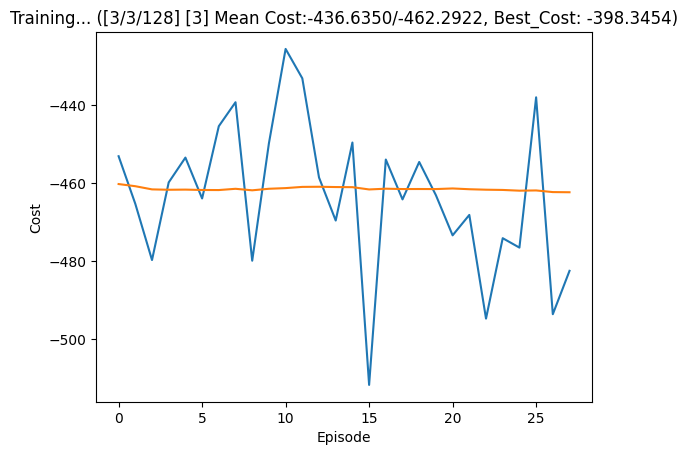

In [16]:
#Train the neural network
#If dedicated GPU is found, run 6000 episodes, else run 600 episodes
if torch.cuda.is_available():
    num_episodes = 40000
else:
    num_episodes = 600
best_cost = -1e16
best_mean_cost=-1e16
best_episode = 0
best_mean_episode = 0
last_best_episode = 0
best_path = []
DEBUG = False
for i_episode in range(num_episodes):
    """
    if i_episode%5==0:
    #Creating problem instance using defined variables
        info_vector, customer_location_matrix, truck_location_matrix, \
        customer_demand_matrix, truck_capacity_matrix, customer_location_list = \
        instance_creator(cust_max_dem, truck_cap, num_cust, num_row, num_col)
        #For this instance, set starting truck location to depot location
        truck_location_matrix[info_vector[0][0],info_vector[0][1]]=1
        truck_start_location = (np.where(truck_location_matrix==1)[0][0], np.where(truck_location_matrix==1)[1][0])
        #Set at the location of the truck, the starting demand to the max truck capacity
        truck_capacity_matrix[info_vector[0][0],info_vector[0][1]]=info_vector[1]
        state, info = env.update(info_vector, customer_location_matrix, truck_location_matrix, customer_demand_matrix,\
        truck_capacity_matrix, customer_location_list, truck_start_location)
    # Initialize the environment and get it's state
    else:
    """
    state, info = env.reset()
    path=[]
    if DEBUG: 
        print(f"[{i_episode}] State: {state}")
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    env.reorder_customers()
    env.update()
    total_cost = 0.0
    visited = [0]
    for t in count():
        #Print information for debugging and training
        invalid_ones = env.get_invalid_ones()
        if DEBUG:
            print(f"{t} -------------------------------------------------")
            print(f'invalid_ones = {invalid_ones}')
        action = select_action(state, invalid_ones)
        path.append(action.item())
        if DEBUG: 
            print(f"action selected: {action.item()}")
            print(f"path so far: {path}")
        observation, reward, terminated, truncated, info = env.step(action.item())
        if DEBUG: 
            print(f"Step done ---------------------")
            print(f"observation: {observation}")
            print(f"reward: {reward}")
            print(f"terminated: {terminated}, truncated: {truncated}")
        v = env.get_visited()
        u = env.get_unvisited()
        if DEBUG: 
            print(f"visited: {v}")
            print(f"unvisited: {u}")
        total_cost = total_cost + reward
        visited = copy.deepcopy(info["visited"])
        if action.item() not in visited:
            visited.append(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        # print(f"Memory length: {len(memory)}")

        if done:
            episode_costs.append(total_cost)
            memory_size = len(memory)
            if memory_size > REPLAY_MEM_SIZE:
                replay = True
            else:
                replay = False
            mean = np.mean(episode_costs[-100:])
            if total_cost == best_cost:
                last_best_episode=i_episode
            if total_cost>best_cost:
                best_cost=total_cost
                best_path=path
                best_episode = i_episode
                last_best_episode=i_episode
            if mean>best_mean_cost:
                best_mean_cost=mean
                best_mean_episode=i_episode
            title_str = f'[{best_episode}/{last_best_episode}/{i_episode}] [{best_mean_episode}] Mean Cost:{best_mean_cost:.4f}/{mean:.4f}, Best_Cost: {best_cost:.4f}'
            plot_costs(title_str=title_str)
            break
    optimize_model()
    # Perform one step of the optimization (on the policy network)
#        optimize_model()
    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)
print(f"[{best_episode}: Best cost: {best_cost} and best path: {best_path}")
print('Complete')
# HERE
plot_costs(show_result=True)
plt.ioff()
plt.show()

In [ ]:
path

In [ ]:
best_cost

In [ ]:
best_path

In [ ]:
total_cost

## Test the trained network

In [ ]:
#Reset environment
state, info = env.reset()
visited = [0]
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

total_cost = 0  # Variable to store the total reward for this episode
actions_taken = []  # List to store the actions taken

In [ ]:
#See the state info
state

In [ ]:
#Run first step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Second step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Third step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Fourth step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Fifth step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Sixth step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Seventh step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Eigth step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")

In [ ]:
#Ninth step
action = select_action(state, visited)
print(f"action selected: {action}")
observation, reward, terminated, truncated, info = env.step(action.item())
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {terminated}, truncated: {truncated}")
v = env.get_visited()
u = env.get_unvisited()
print(f"visited: {v}")
print(f"unvisited: {u}")
total_cost = total_cost + reward
visited = copy.deepcopy(info["visited"])
if action.item() not in visited:
    visited.append(action.item())
done = terminated or truncated
print(f"Total cost so far: {total_cost}")